# Diagramación de una Chacra para Forestería Análoga

### © Equipo I+D SomosAZUCAR - Bajo licencia AGPLv3

```
Diagramador de Planos para Forestería Análoga
Copyright (C) 2015 Sebastian Silva

This program is free software: you can redistribute it and/or modify
it under the terms of the GNU Affero General Public License as published by
the Free Software Foundation, either version 3 of the License, or
(at your option) any later version.

This program is distributed in the hope that it will be useful,
but WITHOUT ANY WARRANTY; without even the implied warranty of
MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
GNU Affero General Public License for more details.

You should have received a copy of the GNU Affero General Public License
along with this program.  If not, see <http://www.gnu.org/licenses/>.
```

In [3]:
# Bibliotecas utilizadas para confeccionar el mapa
%matplotlib inline
import matplotlib.pyplot as plt
from shapely import geometry
import numpy as np
import pandas as pd
import random
import mpld3
from tqdm import tqdm

## 1.- DATOS INICIALES
### © Arbio - licencia por definir

La base de datos consiste en una lista de especies, cantidades, diámetro, y características.

In [35]:
especies = pd.read_csv("db_final.csv") ## Es una base
#especies = especies[(especies.Estrato==5)]
especies = especies.sort('Estrato', ascending=False)
especies = especies[(especies.Usos=="Medicinal")]

In [36]:
consolidado = pd.DataFrame({'especies':especies.groupby('Estrato').size(), 
                            'individuos':especies.groupby('Estrato')['ind'].sum()})
pd.concat([consolidado,pd.DataFrame(consolidado.sum(axis=0),columns=['Total']).T])


,especies,individuos
Estrato,,
1,4,612
2,6,132
3,8,56
4,7,28
5,2,8
Total,27,836


## 2.- LINDEROS DE LA CHACRA

Los linderos están definidos como un polígono en metros, desde una de las esquinas.

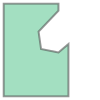

In [37]:
chacra = geometry.Polygon([ [0,0],
                            [0, 93],
                            [55, 93],
                            [55, 86],
                            [35, 65],
                            [37.5, 47.5],
                            [55, 44],
                            [65, 52.5],
                            [65, 0] ])
chacra

## 3.- Definir ubicaciones

In [38]:
def punto_aleatorio(poligono):
    (minx, miny, maxx, maxy) = poligono.bounds
    while True:
        p = geometry.Point(random.uniform(minx, maxx), random.uniform(miny, maxy))
        if poligono.contains(p):
            return(p)

In [79]:
def regla_1(poblacion, planta):
    # Regla 1: La distancia al lindero debe ser mayor que la mitad de la altura
    if planta.pos.distance(poblacion.poligono.exterior) < planta['Altura.tot'] * 0.75:
        raise ValueError('regla1')
                
def regla_2(poblacion, planta):
    for anterior in poblacion.individuos.itertuples():
        if planta.pos.distance(anterior[2]) < planta.Distancia / 2:
            raise ValueError('regla2')

In [80]:
class Poblacion:
    def __init__(self, poligono, especies):
        self.poligono = poligono
        individuos_columns = ['id', 'pos', 'x', 'y', 'color', 'Diametro.dosel', 'Nombre']
        self.individuos = pd.DataFrame( columns=individuos_columns, )
        self.n_individuos = 0
        self.inubicables = 0
        for especie in tqdm(list(especies.itertuples())):
            n_especie = especie[0]
            color_especie = np.random.rand(3,)
            planta_tipo = especies.loc[n_especie]
            for n_individuo in range(especies.ind[n_especie]):
                self.n_individuos = self.n_individuos + 1
                planta = planta_tipo.copy()
                planta['id'] = n_especie
                planta = self.ubicar(planta)
                if planta['pos']:
                    planta['color'] = color_especie
                    planta['diametro'] = int(float(planta['Diametro.dosel'])*10)
                    self.individuos.loc[self.n_individuos] = planta
                self.individuos = self.individuos.dropna()
        if self.inubicables:
            print ("No se pudieron ubicar " + str(self.inubicables) + " individuos.")
            #self.inubicables = pd.DataFrame(self.inubicables)
                        
    def ubicar(self, planta):
        intentos = 100
        while intentos:
            intentos = intentos - 1
            distancia_min = 1 # 1m
                
            pos = punto_aleatorio(self.poligono)       
            planta['pos'] = pos
            planta['x'], planta['y'] = pos.xy
            
            try:
                regla_1(self, planta)
                regla_2(self, planta)
            except ValueError as e:
                next
            else:
                return planta
            
        self.inubicables = self.inubicables + 1
        planta['pos'] = None                
        return planta

In [81]:
# Demora bastante
pob = Poblacion(chacra, especies)

No se pudieron ubicar 16


In [85]:
print ("Se ubicaron %s de %s individuos." % 
        ( len(pob.individuos), especies.ind.sum(axis=0)))

Se ubicaron 820 de 836 individuos.


## 4.- Graficar el mapa

Empezamos por los linderos de la chacra.

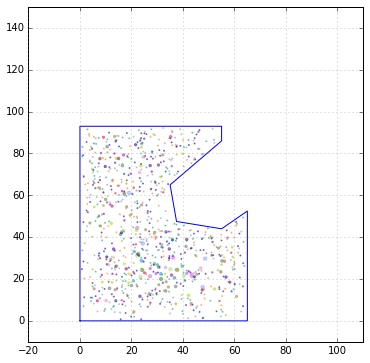

In [71]:
fig = plt.figure(figsize=(6, 6))
chacra_x, chacra_y = chacra.exterior.xy
ax = fig.add_subplot(111)
ax.set_ylim(-10,150)
ax.set_xlim(-20,110)
ax.plot( *chacra.exterior.xy )
ax.scatter(list(pob.individuos.x), 
           list(pob.individuos.y), 
           color=list(pob.individuos.color), 
           s=list(pob.individuos["Diametro.dosel"]), 
           alpha=0.5)
ax.grid(color='gray', alpha=0.9)

In [ ]:
# Gráfico interactivo
mpld3.display(fig)